# RNA - Trabajo Práctico 1 - E2
Jonathan Teran <jteran@dc.uba.ar>

En este notebook exploraremos tecnicas y modelos para una red neuronal que resuelva el ejercicio 2 del TP1

## Eficiencia energética

Los datos los recibimos en el archivo `tp1_ej2_training.csv`, siendo las primeras 8 columnas las características de un edificio distinto, y las últimas 2 columnas la respuesta esperada para del modelo. En un principio no nos interesan que representa cada dato, así que arrancaremos por normalizarlos cargarlos del csv y normalizarlos.

In [1]:
# importamos librería necesarias
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def normalize(x):
    return (x - x.mean(0)) / x.std(0, ddof=1)

def denormalize(x, med, std):
    return x * std + med

In [5]:
# cargar datos
DATA_FILE = 'tp1_ej2_training.csv'
df = np.loadtxt(DATA_FILE, delimiter=',')
X  = df[:,:-2]
Z0  = df[:,-2:]
Zmed = Z0.mean(0)
Zstd = Z0.std(0, ddof=1)
# normalizar data
X  = normalize(X)
Z  = normalize(Z0)

A continuación definiremos variables que definirán nuestro modelo, como la cantidad de nodos por capa, o la distribución de los datos en datos de testeo, validación y entrenamiento.

Utilizaremos los datos de entrenamiento para entrenar la red, los de validación para verificar si el modelo es apropiado o deberíamos cambiarlo, y cuando nos hayamos decidido por un modelo particular, usaremos los de testeo para comprobar que tanto puede generalizar a otras instancias.

In [67]:
P = len(X)
N = X.shape[1] # unidades de entrada
M = Z.shape[1] # unidades de salida
S = [N, 8, 8, M] # distribución de nodos por capa
L = len(S) # cantidad de capas
LR = 0.15 # learning rate
LR_A = 0.03 # incrementar con este valor si el error disminuyo
LR_B = 1e-2 # decrementar en LR*LR_Bsi el error aumento
LR_K = 4    # si el error disminuyo en las ultimas LR_K veces, incrementar LR
EMAR = 0.05 # margen de error
MOM = 0.9

# cantidades reservadas para: 
C_T = int(P * .05)  # testeo
C_V = int(P * .15)  # validacion
C_E = P - C_T - C_V # entrenamiento

B = 1 # tamaños para los mini-lotes

Finalmente, definiremos las funciones del modelo.

In [7]:
def bias_add(a):
    return np.concatenate((a, -np.ones((len(a),1))), axis=1)

def bias_del(a):
    return a[:,:-1]

In [8]:
def activacion(X, W):
    b = len(X)
    # nodos por capa + nodo extra para el bias
    Y = [ np.empty((b, S[i]+1)) for i in range(L)]
    Y[L-1] = np.empty((b, M))
    # Y sin bias
    Ysb = X
    for i in range (1, L):
        Y[i-1][:,:] = bias_add(Ysb)
        Ysb = np.tanh(np.dot(Y[i-1], W[i-1]))
    Y[L-1][:,:] = Ysb
    
    return Y

In [9]:
def correccion(W, Y, Z, _dW = None):
    b = len(Z)
    dW = [ np.empty_like(w) for w in W ]
    D  = [ np.empty_like(y) for y in Y]
    E  = Z - Y[L-1]
    dY = 1 - np.square(Y[L-1])
    D[L-1] = np.multiply(E, dY)
    
    for k in range(L-1, 0, -1):
        dE = [ np.outer(Y[k-1][i], D[k][i]) for i in range(b) ]
        dW[k-1] = LR * np.mean(dE, axis=0) + (MOM*_dW[k-1] if _dW != None else 0)
        E = np.dot(D[k], W[k-1].T)
        dY = 1 - np.square(Y[k-1])
        D[k-1] = bias_del(np.multiply(E, dY))
    
    return dW

In [10]:
def adaptacion(W, dW):
    return [ W[i] + dW[i] for i in range(L-1) ]

In [75]:
def entrenamiento(W, X, Z):
    global LR
    t_max = 2000
    t = 0
    errores = []
    val = []
    lrval = []
    k = 0
    while t < t_max:
        e = 0
        indices = np.random.permutation(len(X))
        dW = None
        _E = None # ultimo error
        for batch in range(0, len(indices), B):
            h  = indices[batch : batch+B]
            Xh = X[h]
            Zh = Z[h]
            Yh = activacion(Xh, W)
            E = np.square(Zh -Yh[L-1]).sum() / 2
            dE = _E - E if _E != None else 0
            _E = E
            if dE > 0:
                LR -= LR_B * LR
                k = 0
                W = adaptacion(W, [ -dw for dw in dW ]) # deshacer ultimo paso
            elif dE < 0:
                k += 1
                if k == LR_K:
                    LR += LR_A
                    k -= 1
            e += np.mean(np.square(np.subtract(Zh, Yh[L-1])))
            dW = correccion(W, Yh, Zh, dW)
            W  = adaptacion(W, dW)
        errores.append(e)
        if t % 100 == 0:
            print("#", t)
            print("e  =", e)
            print("LR =", LR)
            val.append(validacion(W, X, Z0[h_ent]))
        if t % 10 == 0:
            lrval.append(LR)
        t += 1
    plt.plot(errores, 'r')
    plt.show()
    plt.plot(val, 'g')
    plt.show()
    plt.plot(lrval, 'b')
    plt.show()
    
    return W

In [12]:
def init_pesos():
    W = [ np.random.randn(S[i]+1, S[i+1]) * np.sqrt(2/S[i]) for i in range(L-1) ]
    return W

In [13]:
def validacion(W, X, Z):
    Y = activacion(X, W)
    Y = denormalize(Y[L-1], Zmed, Zstd)
    V = np.abs(Z - Y) / Z # % de error
    U = (V < EMAR).flatten()
    ok = 0
    for u in U:
        if u == True:
            ok += 1
    return ok / len(U)

# 0
e  = 12.517042512441414
LR = 0.042934081648838406
# 100
e  = 5.3494924971663655
LR = 0.059213771277840194
# 200
e  = 5.053748972967745
LR = 0.03127642416657152
# 300
e  = 4.182283308106863
LR = 0.06392524486817877
# 400
e  = 4.0770942391850475
LR = 0.037004378083307914
# 500
e  = 4.058321411013711
LR = 0.041190113849159236
# 600
e  = 4.040204936841648
LR = 0.03296571989101594
# 700
e  = 4.0232161803193955
LR = 0.045666163448329036
# 800
e  = 4.003860719277887
LR = 0.0285954820854468
# 900
e  = 4.00332276243309
LR = 0.030637717491836317
# 1000
e  = 4.008692636325793
LR = 0.051804476219601506
# 1100
e  = 3.9941601694265496
LR = 0.037168268008833355
# 1200
e  = 3.982656060562745
LR = 0.03075119039355796
# 1300
e  = 3.974819909893946
LR = 0.03903655675505112
# 1400
e  = 3.954051579880206
LR = 0.04297189580346746
# 1500
e  = 4.0108420955911255
LR = 0.06837148066132251
# 1600
e  = 3.9685766282443447
LR = 0.06799518842341676
# 1700
e  = 3.92244574713588
LR = 0.04881336271455985
# 1800
e  

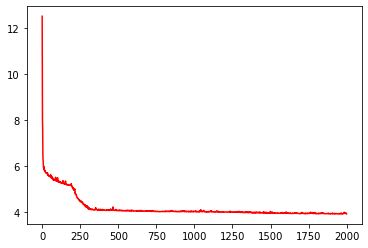

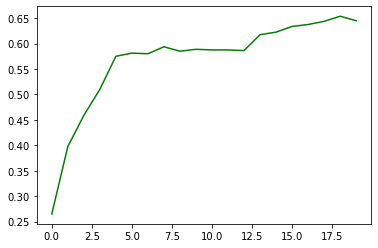

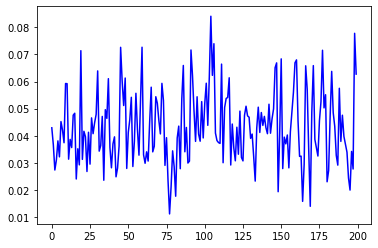

0.64


In [77]:
S = [N, 10, 16, 4, M] # distribución de nodos por capa
L = len(S) # cantidad de capas
LR = 5e-2 # learning rate
LR_A = 5e-3 # incrementar con este valor si el error disminuyo
LR_B = 1e-2 # decrementar en LR*LR_Bsi el error aumento
LR_K = 3    # si el error disminuyo en las ultimas LR_K veces, incrementar LR
EMAR = 0.05 # margen de error
MOM = 0.9

B = 8 # tamaños para los mini-lotes

# ENTRENAMIENTO
# usaremos los datos de entrenamiento y de validación para entrenar la
# red y evaluar si los resultados obtenidos son buenos o no.
W = init_pesos()
h_ent = range(0, C_E)
W = entrenamiento(W, X[h_ent], Z[h_ent])
h_val = range(C_E+1, P-C_T+1)
print(validacion(W, X[h_val], Z0[h_val]))

# 100
e  = 5.974249750922556
LR = 0.060142387068455906
# 200
e  = 5.315148300444957
LR = 0.04565630511873673
# 300
e  = 5.165097153018028
LR = 0.05914456975664392
# 400
e  = 5.201633391459702
LR = 0.04170458411255618
# 500
e  = 5.289489132167617
LR = 0.13902824028412966
# 600
e  = 5.4176845088860395
LR = 0.012567101961975899
# 700
e  = 5.145151187425664
LR = 0.0596496175666809
# 800
e  = 5.129708009745166
LR = 0.05849417773784502
# 900
e  = 5.115588091837702
LR = 0.0391067398635406
# 1000
e  = 5.193784672102173
LR = 0.02773852737938466
# 1100
e  = 5.110724061734424
LR = 0.08765727242124206
# 1200
e  = 5.360385130632604
LR = 0.0459339695901255
# 1300
e  = 5.054076890208803
LR = 0.0620390274285385
# 1400
e  = 5.080993399012586
LR = 0.006763231521081918
# 1500
e  = 5.152769588019703
LR = 0.07558006711279833
# 1600
e  = 5.038483421909774
LR = 0.11932589253654258
# 1700
e  = 5.329960997205025
LR = 0.14746986382579227
# 1800
e  = 4.918777181896159
LR = 0.0075821049705212884
# 1900
e  = 4.857

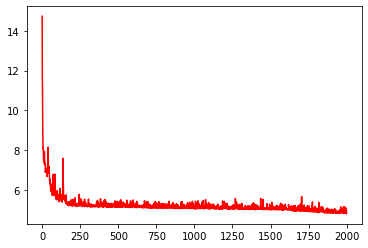

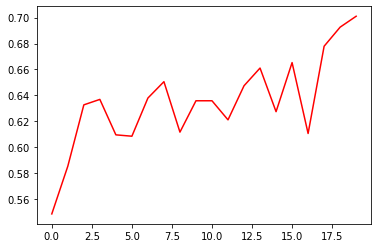

0.44


In [109]:
# TESTING
# una vez que encontramos un buen modelo, incluimos los datos de validacion
# para entrenar la red y testeamos los resultados con los datos de test
W = init_pesos()
h_ent = range(0, P-C_T) # todos los datos menos los ultimos C_T
W = entrenamiento(W, X[h_ent], Z[h_ent])
h_test = range(P-C_T, P)
print(validacion(W, X[h_test], Z[h_test]))